## Aim

The prevalence of the interneuron hub mircorcircuit led us to the hypothesis that the interneurons mediate lateral inhibition. For effective lateral inhibition, the more active excitatory neuron has to be less sensitive to the inhibitory inputs than the less active one. This difference in sensitivity could stem from the timing of inhibition. The more active neuron is more likely to produce a spike in the interneuron, so that it receives the inhibition at a short time after spiking. In contrast, the less active neuron has a high chance to receive the inhibition in a later phase. How this timing of inhibition translates into sensitivity depends on the neuron model. Generally, however, most neuron models are less senstive to input directly after the spike than input in the middle of the phase.

We demonstrated the lateral inhibition with a model of Hodgkin-Huxley dynamics. Here, one important factor for the difference in senstivity is the relatively strong after-hyperpolarisation. When the membrane is hyperpolarised, inhibitory conductances cannot further inhibit the neuron, so that their effect is diminished. However, most pyramidal cells exhibit a reduced after-hyperpolarisation. Therefore, we would like to test the robustness of our results in more pyramidal-like neuron models.

For a different neuron model, I read Pospischil, 2008, an article claiming to provide model classes for four different neuron types (regular spiking, fast spiking, bursting and low threshold spiking). However, for their model fitting, they focus more on **spike timing** ("The error function consisted of a weighted sum over the absolute value of the differences in the time of the first spike after DC onset, the first, second and last interspike intervals, all values taken at three different DC levels" and "In order to avoid that an (experimentally) unreliable feature strongly impacts on the error function, we chose the weights wi to be the inverse of the SD of the experimental values. Large SDs thus lead to a reduced contribution to the error. However, in order to prevent an error that predomi-nantly consists of the contribution of a very reliable feature, we introduced a cut-off: whenever the SD of a given feature was smaller than 3% of the mean experimental value, the weight was taken as the inverse of these 3%, rather than as the inverse of the SD itself."). In almost all figures, there is a clear difference between the experimentally observed spike shapes and the modelled ones. 

1. Pospischil, M. et al. Minimal Hodgkin-Huxley type models for different classes of cortical and thalamic neurons. Biol. Cybern. 99, 427–441 (2008).


#### Brian2Model Fitting
I thought one interesting route could be to use Yanfangs recordings to do a custom fitting that puts more emphasis on the spike shape. For this reason, I will try the [Brian2 model fitting toolbox](https://brian2modelfitting.readthedocs.io/en/stable/index.html).

Installation

pip install brian2modelfitting did not work for me, because I did not get the right nevergrad version, which was related to this bug https://github.com/brian-team/brian2modelfitting/issues/24. So I cloned the repro and installed it from there.

## Generate target dynamics

In [1]:
from brian2.units import *
import brian2 as br

In [2]:
area = 20000 * umetre ** 2
hodgkin_huxley_params = {
    "Cm": 1 * ufarad * cm ** -2 * area,
    "gl": 5e-5 * siemens * cm ** -2 * area,
    "El": -65 * mV,
    "EK": -80 * mV,
    "ENa": 50 * mV,
    "g_na": 100 * msiemens * cm ** -2 * area,
    "g_kd": 30 * msiemens * cm ** -2 * area,
    "VT": -63 * mV
}

hodgkin_huxley_eqs = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I )/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
'''

I_eqs = '''
I: amp'''

In [3]:
inputs = [0.2*nA, 0.5*nA]
dt = 0.1*ms
duration = 100*ms

br.brian_prefs.dt = dt 
number_of_inputs = len(inputs)

neuron = br.NeuronGroup(N=number_of_inputs, model=hodgkin_huxley_eqs+I_eqs, method="exponential_euler", threshold="v>-40*mV", refractory="v>-40*mV")

trace_monitor = br.StateMonitor(neuron, ['v'], record=True)
net = br.Network(neuron)
net.run(100*ms, namespace=hodgkin_huxley_params)

v_eq = neuron.v[0]
m_eq = neuron.m[0]
h_eq = neuron.h[0]
n_eq = neuron.n[0]

net.add(trace_monitor)
for neuron_idx in range(number_of_inputs):
    neuron.I[neuron_idx]=inputs[neuron_idx]
    
net.run(duration,namespace=hodgkin_huxley_params)


In [4]:
import matplotlib.pyplot as plt

(100, 200)

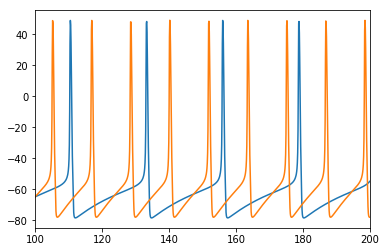

In [5]:
for idx in range(number_of_inputs):
    plt.plot(trace_monitor.t/ms, trace_monitor.v[idx][:]/mV)
plt.xlim(100, 200)

In [6]:
output_traces = trace_monitor.v[:]

In [7]:
output_traces.shape

(2, 1000)

In [8]:
import numpy as np

In [9]:
input_traces = np.repeat(np.array([inputs]), output_traces.shape[1], axis=0).T*amp

In [10]:
input_traces.shape

(2, 1000)

## Create a fitter

In [11]:
import brian2modelfitting as mf

WARNING    /home/pfeiffer/.local/lib/python3.7/site-packages/tqdm-4.31.1-py3.7.egg/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [12]:
parameter_eqs = '''
g_na : siemens (constant)
g_kd : siemens (constant)
ENa: volt (constant)
EK: volt (constant)
'''

Cm =  1 * ufarad * cm ** -2 * area
gl =  5e-5 * siemens * cm ** -2 * area
El =  -65 * mV
VT =  -63 * mV

In [13]:
fitter = mf.TraceFitter(dt=0.1*ms,
                        model=hodgkin_huxley_eqs+parameter_eqs,
                        input_var="I",
                        output_var="v",
                        input=input_traces,
                        output=output_traces,
                        method='exponential_euler',
                        n_samples = 10,
                        param_init={"v":v_eq, "m": m_eq, "n": n_eq, "h": h_eq})

In [14]:
opt = mf.NevergradOptimizer(num_workers=3)
metric = mf.MSEMetric()

In [22]:
res, error = fitter.fit(n_rounds = 100, optimizer=opt, metric=metric, g_na=[0.33*hodgkin_huxley_params["g_na"], 3*hodgkin_huxley_params["g_na"]], g_kd = [0.33*hodgkin_huxley_params["g_kd"], 3*hodgkin_huxley_params["g_kd"]], ENa = [0.33*hodgkin_huxley_params["ENa"], 3*hodgkin_huxley_params["ENa"]], EK = [ 3*hodgkin_huxley_params["EK"], 0.33*hodgkin_huxley_params["EK"]])

Round 0: Best parameters EK=-78.34272938 mV, ENa=27.27076459 mV, g_kd=13.46178134 uS, g_na=22.89360602 uS (error: 402.19317278 mV^2)
Round 1: Best parameters EK=-78.34272938 mV, ENa=27.27076459 mV, g_kd=13.46178134 uS, g_na=22.89360602 uS (error: 402.19317278 mV^2)
Round 2: Best parameters EK=-78.28625021 mV, ENa=24.17809884 mV, g_kd=15.53226421 uS, g_na=17.6488482 uS (error: 386.69997268 mV^2)
Round 3: Best parameters EK=-80.29287141 mV, ENa=25.47313302 mV, g_kd=9.31321283 uS, g_na=31.45285497 uS (error: 193.02621214 mV^2)
Round 4: Best parameters EK=-80.29287141 mV, ENa=25.47313302 mV, g_kd=9.31321283 uS, g_na=31.45285497 uS (error: 193.02621214 mV^2)
Round 5: Best parameters EK=-80.29287141 mV, ENa=25.47313302 mV, g_kd=9.31321283 uS, g_na=31.45285497 uS (error: 193.02621214 mV^2)
Round 6: Best parameters EK=-80.29287141 mV, ENa=25.47313302 mV, g_kd=9.31321283 uS, g_na=31.45285497 uS (error: 193.02621214 mV^2)
Round 7: Best parameters EK=-80.29287141 mV, ENa=25.47313302 mV, g_kd=9.31

Round 64: Best parameters EK=-79.25331479 mV, ENa=29.1855946 mV, g_kd=14.38383269 uS, g_na=23.84749322 uS (error: 61.92135698 mV^2)
Round 65: Best parameters EK=-79.25331479 mV, ENa=29.1855946 mV, g_kd=14.38383269 uS, g_na=23.84749322 uS (error: 61.92135698 mV^2)
Round 66: Best parameters EK=-79.25331479 mV, ENa=29.1855946 mV, g_kd=14.38383269 uS, g_na=23.84749322 uS (error: 61.92135698 mV^2)
Round 67: Best parameters EK=-79.25331479 mV, ENa=29.1855946 mV, g_kd=14.38383269 uS, g_na=23.84749322 uS (error: 61.92135698 mV^2)
Round 68: Best parameters EK=-79.25331479 mV, ENa=29.1855946 mV, g_kd=14.38383269 uS, g_na=23.84749322 uS (error: 61.92135698 mV^2)
Round 69: Best parameters EK=-79.25331479 mV, ENa=29.1855946 mV, g_kd=14.38383269 uS, g_na=23.84749322 uS (error: 61.92135698 mV^2)
Round 70: Best parameters EK=-79.25331479 mV, ENa=29.1855946 mV, g_kd=14.38383269 uS, g_na=23.84749322 uS (error: 61.92135698 mV^2)
Round 71: Best parameters EK=-79.25331479 mV, ENa=29.1855946 mV, g_kd=14.383

In [23]:
res

{'EK': -79.56861212 * mvolt,
 'ENa': 22.93187477 * mvolt,
 'g_na': 27.10457024 * usiemens,
 'g_kd': 11.44286746 * usiemens}

In [24]:
hodgkin_huxley_params["g_na"]

20. * usiemens

In [25]:
hodgkin_huxley_params["g_kd"]

6. * usiemens

In [26]:
traces = fitter.generate_traces()

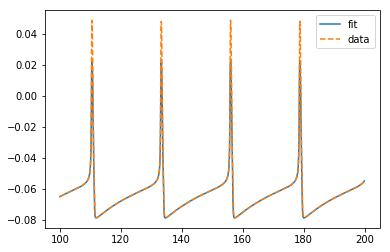

In [27]:
plt.plot(trace_monitor.t/ms, traces[0,:], label="fit")
plt.plot(trace_monitor.t/ms, output_traces[0,:], linestyle= '--', label="data")
plt.legend()

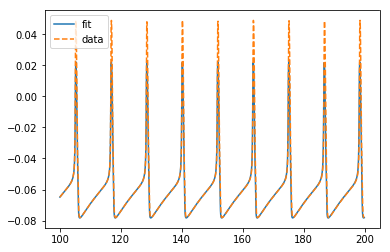

In [28]:
plt.plot(trace_monitor.t/ms, traces[1,:], label="fit")
plt.plot(trace_monitor.t/ms, output_traces[1,:], linestyle= '--', label="data")
plt.legend()